In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import tensorflow_datasets as tfds
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, InputLayer, Flatten, BatchNormalization, Layer, Input, RandomRotation, RandomContrast, RandomFlip, Resizing, Rescaling
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras import Model
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow_probability as tfp


In [2]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d puneet6060/intel-image-classification

Dataset URL: https://www.kaggle.com/datasets/puneet6060/intel-image-classification
License(s): copyright-authors
100% 346M/346M [00:01<00:00, 254MB/s]
100% 346M/346M [00:01<00:00, 247MB/s]


In [3]:
!unzip 'intel-image-classification'

Streaming output truncated to the last 5000 lines.
  inflating: seg_train/seg_train/mountain/7506.jpg  
  inflating: seg_train/seg_train/mountain/7537.jpg  
  inflating: seg_train/seg_train/mountain/7539.jpg  
  inflating: seg_train/seg_train/mountain/7551.jpg  
  inflating: seg_train/seg_train/mountain/7560.jpg  
  inflating: seg_train/seg_train/mountain/7565.jpg  
  inflating: seg_train/seg_train/mountain/7578.jpg  
  inflating: seg_train/seg_train/mountain/7581.jpg  
  inflating: seg_train/seg_train/mountain/7586.jpg  
  inflating: seg_train/seg_train/mountain/7647.jpg  
  inflating: seg_train/seg_train/mountain/7652.jpg  
  inflating: seg_train/seg_train/mountain/7654.jpg  
  inflating: seg_train/seg_train/mountain/7662.jpg  
  inflating: seg_train/seg_train/mountain/767.jpg  
  inflating: seg_train/seg_train/mountain/7672.jpg  
  inflating: seg_train/seg_train/mountain/7679.jpg  
  inflating: seg_train/seg_train/mountain/7681.jpg  
  inflating: seg_train/seg_train/mountain/7693.jp

In [2]:
train_dir = '/content/seg_train/seg_train/'
test_dir = '/content/seg_test/seg_test/'

In [3]:
class_names = [name for name in os.listdir(train_dir)]
class_names

['buildings', 'forest', 'sea', 'street', 'mountain', 'glacier']

In [4]:
# View an image
def view_random_image(target_dir, target_class):
  # setup target dir
  target_folder = target_dir + target_class
  random_image = random.sample(os.listdir(target_folder), 1)

  # read and plot
  img = mpimg.imread(target_folder + '/' + random_image[0])
  plt.imshow(img)
  plt.title(target_class)
  plt.axis('off')

  print(f'Image shape: {img.shape}')
  return img


Image shape: (150, 150, 3)
Image shape: (150, 150, 3)
Image shape: (150, 150, 3)
uint8


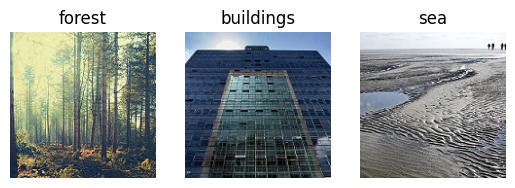

In [5]:
# Visualize Data
plt.figure()
plt.subplot(1, 3, 1)
Fish_img = view_random_image(train_dir, 'forest')
plt.subplot(1, 3, 2)
Otter_img = view_random_image(train_dir, 'buildings')
plt.subplot(1, 3, 3)
Penguin_img = view_random_image(train_dir, 'sea')
print(Penguin_img.dtype)

Image shape: (150, 150, 3)
Image shape: (150, 150, 3)
Image shape: (150, 150, 3)
Image shape: (150, 150, 3)
Image shape: (150, 150, 3)
Image shape: (150, 150, 3)


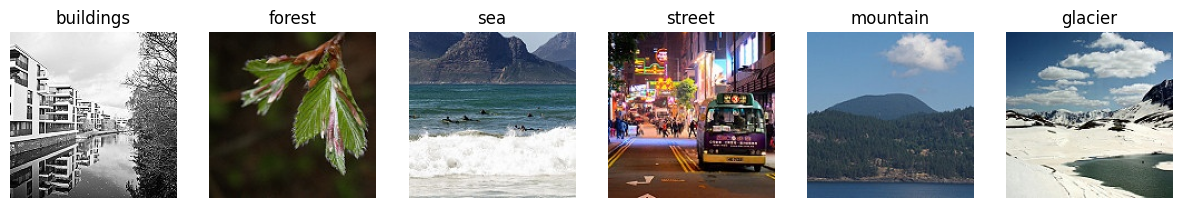

In [6]:
count = 0
plt.figure(figsize=(15,15))
for class_name in class_names:
  count=count+1
  plt.subplot(1, len(class_names), count)
  show_img = view_random_image(train_dir, class_name)
  #print(count)

In [ ]:
# Overfitting. To prevent this need to do data_augmentaion

# Data augmentation configuration
train_datagen = ImageDataGenerator(
    rescale=1./255,
    #validation_split=0.2,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Load training data with augmentation
train_data = train_datagen.flow_from_directory(
    train_dir,
    target_size=(128, 128),
    batch_size=32,
    color_mode="rgb",
    shuffle=True,
    #subset='training',
    class_mode='categorical'
)

# Load validation data without augmentation
validation_datagen = ImageDataGenerator(rescale=1./255)
validation_data = validation_datagen.flow_from_directory(
    test_dir,
    target_size=(128, 128),
    batch_size=32,
    color_mode="rgb",
    #subset='validation',
    class_mode='categorical'
)


Found 14034 images belonging to 6 classes.
Found 3000 images belonging to 6 classes.


In [ ]:
class FeatureExtractor(Layer):
  def __init__(self, filters, kernel_size, strides, padding, activation, pool_size):
    super(FeatureExtractor, self).__init__()

    self.Conv2D_1 = Conv2D(filters=filters, kernel_size=kernel_size, strides=strides, padding=padding, activation=activation)
    self.batch_normalization_1 = BatchNormalization()
    self.MaxPool2D_1 =  MaxPool2D(pool_size=pool_size, strides=2*strides)

    self.Conv2D_2 = Conv2D(filters=2*filters, kernel_size=kernel_size, strides=strides, padding=padding, activation=activation)
    self.batch_normalization_2 = BatchNormalization()
    self.MaxPool2D_2 =  MaxPool2D(pool_size=pool_size, strides=2*strides)


  def call(self, x):
    x = self.Conv2D_1(x)
    x = self.batch_normalization_1(x)
    x = self.MaxPool2D_1(x)

    x = self.Conv2D_2(x)
    x = self.batch_normalization_2(x)
    x = self.MaxPool2D_2(x)
    return x
feature_sub_classed = FeatureExtractor(8, 3, 1, "valid", "relu", 2)


In [ ]:
class LenetModel(Model):
  def __init__(self):
    super(LenetModel, self).__init__()

    self.feature_extractor = FeatureExtractor(8, 3, 1, "valid", "relu", 2)
    self.flatten = Flatten()
    self.dense_1 = Dense(100, activation = 'relu')
    self.batch = BatchNormalization()
    self.dense_2 = Dense(10, activation = 'relu')
    self.batch_2 = BatchNormalization()
    self.dense_3 = Dense(len(class_names), activation = 'softmax')

  def call(self, x):
    x = self.feature_extractor(x)
    x = self.flatten(x)
    x = self.dense_1(x)
    x = self.batch(x)
    x = self.dense_2(x)
    x = self.batch_2(x)
    x = self.dense_3(x)

    return x

lenet_subclass_model = LenetModel()
lenet_subclass_model(tf.zeros([1, 128, 128, 3]))
lenet_subclass_model.summary()

Model: "lenet_model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extractor_5 (Featu  multiple                  1488      
 reExtractor)                                                    
                                                                 
 flatten_3 (Flatten)         multiple                  0         
                                                                 
 dense_9 (Dense)             multiple                  1440100   
                                                                 
 batch_normalization_18 (Ba  multiple                  400       
 tchNormalization)                                               
                                                                 
 dense_10 (Dense)            multiple                  1010      
                                                                 
 batch_normalization_19 (Ba  multiple                

In [ ]:
# Compile
lenet_subclass_model.compile(loss='categorical_crossentropy',
                     optimizer=tf.keras.optimizers.Adam(),
                     metrics=['accuracy'])

In [ ]:
# EarlyStopping callback for model_1
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

In [ ]:
# Fit the model
lenet_history = lenet_subclass_model.fit(train_data,
                                  epochs=40,
                                  steps_per_epoch=len(train_data),
                                  validation_data=validation_data,
                                  validation_steps=len(validation_data),
                                  callbacks=[early_stopping]
                                  )

Epoch 1/40
439/439 [==============================] - 76s 161ms/step - loss: 1.1695 - accuracy: 0.5680 - val_loss: 1.1531 - val_accuracy: 0.5667
Epoch 2/40
439/439 [==============================] - 70s 159ms/step - loss: 0.9224 - accuracy: 0.6580 - val_loss: 0.9480 - val_accuracy: 0.6403
Epoch 3/40
439/439 [==============================] - 72s 163ms/step - loss: 0.8266 - accuracy: 0.6988 - val_loss: 0.6863 - val_accuracy: 0.7643
Epoch 4/40
439/439 [==============================] - 69s 156ms/step - loss: 0.7713 - accuracy: 0.7127 - val_loss: 0.9920 - val_accuracy: 0.6370
Epoch 5/40
439/439 [==============================] - 69s 157ms/step - loss: 0.7272 - accuracy: 0.7347 - val_loss: 0.6281 - val_accuracy: 0.7690
Epoch 6/40
439/439 [==============================] - 70s 159ms/step - loss: 0.7158 - accuracy: 0.7360 - val_loss: 1.0682 - val_accuracy: 0.6283
Epoch 7/40
439/439 [==============================] - 69s 157ms/step - loss: 0.6888 - accuracy: 0.7481 - val_loss: 0.6715 - val_ac

<Axes: >

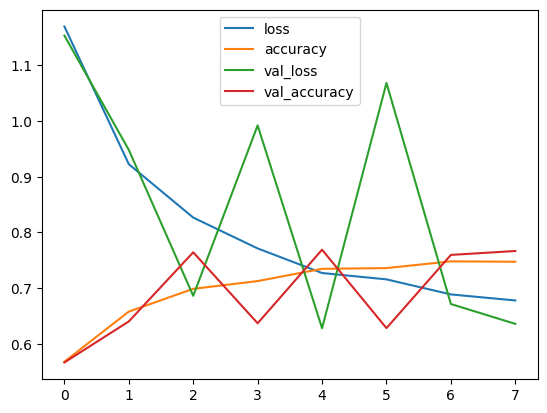

In [ ]:
import pandas as pd
pd.DataFrame(lenet_history.history).plot()

In [ ]:
# Overfitting. To prevent this need to do data_augmentaion

# Data augmentation configuration
train_datagen = ImageDataGenerator(
    rescale=1./255
)

# Load training data with augmentation
train_data = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    color_mode="rgb",
    shuffle=True,
    #subset='training',
    class_mode='categorical'
)

# Load validation data without augmentation
validation_datagen = ImageDataGenerator(rescale=1./255)
validation_data = validation_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    color_mode="rgb",
    #subset='validation',
    class_mode='categorical'
)

Found 14034 images belonging to 6 classes.
Found 3000 images belonging to 6 classes.


In [ ]:
num_samples = len(train_data)
print(f"Number of samples in train_data: {num_samples}")

Number of samples in train_data: 439


In [ ]:
train_data[0]

(array([[[[0.5411765 , 0.5372549 , 0.52156866],
          [0.53333336, 0.5294118 , 0.5137255 ],
          [0.53333336, 0.5294118 , 0.5137255 ],
          ...,
          [0.62352943, 0.61960787, 0.6039216 ],
          [0.62352943, 0.61960787, 0.6039216 ],
          [0.6313726 , 0.627451  , 0.6117647 ]],
 
         [[0.6313726 , 0.627451  , 0.6117647 ],
          [0.62352943, 0.61960787, 0.6039216 ],
          [0.62352943, 0.61960787, 0.6039216 ],
          ...,
          [0.72156864, 0.7176471 , 0.7019608 ],
          [0.72156864, 0.7176471 , 0.7019608 ],
          [0.7254902 , 0.72156864, 0.7058824 ]],
 
         [[0.6313726 , 0.627451  , 0.6117647 ],
          [0.62352943, 0.61960787, 0.6039216 ],
          [0.62352943, 0.61960787, 0.6039216 ],
          ...,
          [0.72156864, 0.7176471 , 0.7019608 ],
          [0.72156864, 0.7176471 , 0.7019608 ],
          [0.7254902 , 0.72156864, 0.7058824 ]],
 
         ...,
 
         [[0.        , 0.        , 0.        ],
          [0.01176

Different Approch

In [7]:
img_size = 256
batch_size = 32
train_dataset = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    labels='inferred',
    label_mode='categorical',
    class_names=class_names,
    color_mode='rgb',
    batch_size=batch_size,
    image_size=(img_size, img_size),
    shuffle=True,
    seed=99,
)

Found 14034 files belonging to 6 classes.


In [8]:
val_dataset = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    labels='inferred',
    label_mode='categorical',
    class_names=class_names,
    color_mode='rgb',
    batch_size=32,
    image_size=(img_size, img_size),
    shuffle=True,
    seed=99,
)

Found 3000 files belonging to 6 classes.


Data Augmentation

In [9]:
# tf.keras.layer Augmentation
augment_layers = tf.keras.Sequential([
    RandomRotation(factor=(-0.025, 0.025)),
    RandomFlip(mode='horizontal'),
    RandomContrast(factor=0.1)
])

In [10]:
train_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 6), dtype=tf.float32, name=None))>

In [11]:
def augment_layer(image, label):
  return augment_layers(image, training = True), label

In [14]:
training_dataset = (
    train_dataset
    .map(augment_layer, num_parallel_calls = tf.data.AUTOTUNE)
    .prefetch(tf.data.AUTOTUNE)
)


In [15]:
training_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 6), dtype=tf.float32, name=None))>

In [16]:
validation_datasets = (
    val_dataset
    .prefetch(tf.data.AUTOTUNE)
)

In [17]:
validation_datasets

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 6), dtype=tf.float32, name=None))>

In [12]:
IM_SIZE=224
resize_rescale_layers = tf.keras.Sequential([
       Resizing(IM_SIZE, IM_SIZE),
       Rescaling(1./255),
])

Lenet Model

In [43]:
lenet_model = tf.keras.Sequential([
    InputLayer(input_shape = (256, 256, 3), ),
    #resize_rescale_layers,
    Conv2D(filters=8, kernel_size=3, strides=1, padding='valid', activation='relu'),
    BatchNormalization(),
    MaxPool2D(pool_size=2, strides=2*1),

    Conv2D(filters=2*8, kernel_size=3, strides=1, padding='valid', activation='relu'),
    BatchNormalization(),
    MaxPool2D(pool_size=2, strides=2*1),

    Flatten(),
    Dense(100, activation = 'relu'),
    BatchNormalization(),
    Dense(10, activation = 'relu'),
    BatchNormalization(),
    Dense(len(class_names), activation = 'softmax')


   ])

lenet_model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 254, 254, 8)       224       
                                                                 
 batch_normalization_8 (Bat  (None, 254, 254, 8)       32        
 chNormalization)                                                
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 127, 127, 8)       0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 125, 125, 16)      1168      
                                                                 
 batch_normalization_9 (Bat  (None, 125, 125, 16)      64        
 chNormalization)                                                
                                                      

In [31]:
# Compile
lenet_model.compile(loss='categorical_crossentropy',
                     optimizer=tf.keras.optimizers.Adam(),
                     metrics=['accuracy'])

In [32]:
# EarlyStopping callback for model_1
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

In [ ]:
# Fit the model
lenet_history = lenet_model.fit(training_dataset,
                                epochs=40,
                                steps_per_epoch=len(training_dataset),
                                validation_data=validation_datasets,
                                validation_steps=len(validation_datasets),
                                callbacks=[early_stopping]
                                )

Epoch 1/40
439/439 [==============================] - 110s 232ms/step - loss: 0.9459 - accuracy: 0.6523 - val_loss: 2.3006 - val_accuracy: 0.3187
Epoch 2/40
439/439 [==============================] - 103s 235ms/step - loss: 0.6752 - accuracy: 0.7554 - val_loss: 1.1602 - val_accuracy: 0.6047
Epoch 3/40
439/439 [==============================] - 104s 237ms/step - loss: 0.5858 - accuracy: 0.7913 - val_loss: 0.5903 - val_accuracy: 0.7920
Epoch 4/40
439/439 [==============================] - 107s 243ms/step - loss: 0.5282 - accuracy: 0.8142 - val_loss: 0.5645 - val_accuracy: 0.8047
Epoch 5/40
439/439 [==============================] - 105s 239ms/step - loss: 0.4917 - accuracy: 0.8266 - val_loss: 0.5996 - val_accuracy: 0.7857
Epoch 6/40
439/439 [==============================] - 104s 235ms/step - loss: 0.4727 - accuracy: 0.8353 - val_loss: 0.8071 - val_accuracy: 0.7140
Epoch 7/40
439/439 [==============================] - 107s 242ms/step - loss: 0.4238 - accuracy: 0.8510 - val_loss: 0.7622 -

<Axes: >

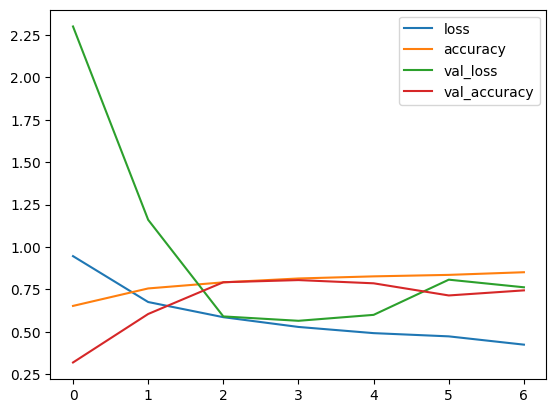

In [ ]:
import pandas as pd
pd.DataFrame(lenet_history.history).plot()

Mixup Augmnetation

In [16]:
train_dataset_1 = train_dataset.shuffle(buffer_size=32,).map(augment_layer, num_parallel_calls = tf.data.AUTOTUNE)
train_dataset_2 = train_dataset.shuffle(buffer_size=32,).map(augment_layer, num_parallel_calls = tf.data.AUTOTUNE)
mixed_dataset = tf.data.Dataset.zip(train_dataset_1, train_dataset_2)

In [17]:
def mixup_augmentation(train_dataset_1, train_dataset_2):
  (image_1, label_1), (image_2, label_2) = train_dataset_1, train_dataset_2
  lamda = tfp.distributions.Beta(0.2, 0.2)
  lamda = lamda.sample(1)[0]

  image = lamda * image_1 + (1-lamda)*image_2
  label = lamda * tf.cast(label_1, dtype=tf.float32) + (1-lamda)*tf.cast(label_2, dtype=tf.float32)

  return image, label


In [36]:
BATCH_SIZE = 32
train_dataset_mix = (
    mixed_dataset
    .shuffle(buffer_size = 32, reshuffle_each_iteration = True)
    .map(mixup_augmentation, num_parallel_calls=tf.data.AUTOTUNE)
    #.batch(BATCH_SIZE)
    .prefetch(tf.data.AUTOTUNE)
)

In [37]:
train_dataset_mix

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 6), dtype=tf.float32, name=None))>

In [38]:
val_dataset_m = (
    val_dataset
    .shuffle(buffer_size = 32, reshuffle_each_iteration = True)
    #.map(mixup_augmentation, num_parallel_calls=tf.data.AUTOTUNE)
    #.batch(BATCH_SIZE)
    .prefetch(tf.data.AUTOTUNE)
)

In [39]:
val_dataset_m

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 6), dtype=tf.float32, name=None))>

In [22]:
tf.debugging.disable_traceback_filtering()

In [44]:
# Compile
lenet_model.compile(loss='categorical_crossentropy',
                     optimizer=tf.keras.optimizers.Adam(),
                     metrics=['accuracy'])

In [45]:
# EarlyStopping callback for model_1
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

In [46]:
# Fit the model
lenet_history_mix = lenet_model.fit(train_dataset_mix,
                                epochs=40,
                                steps_per_epoch=len(train_dataset_mix),
                                validation_data=val_dataset_m,
                                validation_steps=len(val_dataset_m),
                                callbacks=[early_stopping]
                                )

Epoch 1/40
395/439 [=========================>....] - ETA: 19s - loss: 1.1527 - accuracy: 0.6172

InvalidArgumentError: Graph execution error:

Detected at node add_1 defined at (most recent call last):
<stack traces unavailable>
Detected at node add_1 defined at (most recent call last):
<stack traces unavailable>
2 root error(s) found.
  (0) INVALID_ARGUMENT:  Incompatible shapes: [32,6] vs. [18,6]
	 [[{{node add_1}}]]
	 [[IteratorGetNext]]
	 [[IteratorGetNext/_4]]
  (1) INVALID_ARGUMENT:  Incompatible shapes: [32,6] vs. [18,6]
	 [[{{node add_1}}]]
	 [[IteratorGetNext]]
0 successful operations.
0 derived errors ignored. [Op:__inference_train_function_4956]

In [33]:
# Check the number of features in the input data
num_features = train_dataset_mix.element_spec[0].shape[-1]

# Check if the number of features matches the model output
if num_features != lenet_model.output_shape[-1]:
    raise ValueError(
        "The number of features in the input data does not match the model output."
    )

ValueError: The number of features in the input data does not match the model output.

In [34]:
num_features

3

In [35]:
lenet_model.output_shape[-1]

6

In [25]:
# Reshape the input data to match the model output
train_dataset_mix = train_dataset_mix.map(lambda x, y: (tf.reshape(x, (-1, lenet_model.output_shape[-1])), y))
val_dataset_m = val_dataset_m.map(lambda x, y: (tf.reshape(x, (-1, lenet_model.output_shape[-1])), y))

In [26]:
# Check the number of features in the input data
num_features = train_dataset_mix.element_spec[0].shape[-1]

# Check if the number of features matches the model output
if num_features != lenet_model.output_shape[-1]:
    raise ValueError(
        "The number of features in the input data does not match the model output."
    )

In [27]:
num_features

6

In [28]:
lenet_model.output_shape[-1]

6

In [29]:
# Fit the model
lenet_history_mix = lenet_model.fit(train_dataset_mix,
                                epochs=40,
                                steps_per_epoch=len(train_dataset_mix),
                                validation_data=val_dataset_m,
                                validation_steps=len(val_dataset_m),
                                callbacks=[early_stopping]
                                )

Epoch 1/40


ValueError: in user code:

    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/distribute/distribute_lib.py", line 1681, in run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/distribute/distribute_lib.py", line 3271, in call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/distribute/distribute_lib.py", line 4069, in _call_for_each_replica
        return fn(*args, **kwargs)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 61, in error_handler
        return fn(*args, **kwargs)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 590, in __call__
        return super().__call__(*args, **kwargs)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 61, in error_handler
        return fn(*args, **kwargs)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/base_layer.py", line 1149, in __call__
        outputs = call_fn(inputs, *args, **kwargs)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 100, in error_handler
        raise e
    File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 96, in error_handler
        return fn(*args, **kwargs)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/sequential.py", line 398, in call  **
        return super().call(inputs, training=training, mask=mask)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py", line 515, in call
        return self._run_internal_graph(inputs, training=training, mask=mask)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py", line 672, in _run_internal_graph
        outputs = node.layer(*args, **kwargs)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 61, in error_handler
        return fn(*args, **kwargs)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 590, in __call__
        return super().__call__(*args, **kwargs)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 61, in error_handler
        return fn(*args, **kwargs)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/base_layer.py", line 1149, in __call__
        outputs = call_fn(inputs, *args, **kwargs)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 100, in error_handler
        raise e
    File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 96, in error_handler
        return fn(*args, **kwargs)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/sequential.py", line 398, in call  **
        return super().call(inputs, training=training, mask=mask)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py", line 515, in call
        return self._run_internal_graph(inputs, training=training, mask=mask)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py", line 672, in _run_internal_graph
        outputs = node.layer(*args, **kwargs)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 61, in error_handler
        return fn(*args, **kwargs)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/base_layer.py", line 1149, in __call__
        outputs = call_fn(inputs, *args, **kwargs)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 155, in error_handler
        raise new_e.with_traceback(e.__traceback__) from None
    File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 96, in error_handler
        return fn(*args, **kwargs)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/layers/preprocessing/image_preprocessing.py", line 128, in call  **
        outputs = tf.image.resize(
    File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/util/traceback_utils.py", line 141, in error_handler
        return fn(*args, **kwargs)
    File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/util/dispatch.py", line 1260, in op_dispatch_handler
        return dispatch_target(*args, **kwargs)
    File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/ops/image_ops_impl.py", line 1788, in resize_images_v2
        return _resize_images_common(
    File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/ops/image_ops_impl.py", line 1467, in _resize_images_common
        raise ValueError('\'images\' must have either 3 or 4 dimensions.')

    ValueError: Exception encountered when calling layer 'resizing' (type Resizing).
    
    'images' must have either 3 or 4 dimensions.
    
    Call arguments received by layer 'resizing' (type Resizing):
      • inputs=tf.Tensor(shape=(None, 6), dtype=float32)


In [49]:
train_dataset_mix



<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 6), dtype=tf.float32, name=None))>

In [50]:
val_dataset_m

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 6), dtype=tf.float32, name=None))>